<a href="https://colab.research.google.com/github/iBuddyBobby/iBuddyBobby/blob/main/credit_card_Fraud_Dect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# Credit Card Fraud Detection - Research Implementation
# Based on "Simple credit card fraud detection using Machine Learning"
# Author: Nitesh Sakerepalli

# Install required packages
!pip install imbalanced-learn mlflow scikit-learn pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (precision_recall_curve, auc, roc_auc_score,
                           classification_report, confusion_matrix, precision_score, recall_score)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("=== Credit Card Fraud Detection System ===")
print("Implementation based on research proposal methodology")
print("Focus: Simple, cost-effective, interpretable fraud detection")

=== Credit Card Fraud Detection System ===
Implementation based on research proposal methodology
Focus: Simple, cost-effective, interpretable fraud detection


In [28]:
# 1. DATA LOADING AND INITIAL EXPLORATION
print("\n1. DATA LOADING AND EXPLORATION")
print("="*50)

# Load the dataset
try:
    df = pd.read_csv('/content/creditcard.csv')
    print(f"Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print(f"Fraud rate: {df['Class'].mean():.4f} ({df['Class'].sum()} fraudulent transactions)")

    # Display basic info
    print("\nDataset Info:")
    print(df.info())

    # Check for missing values
    print(f"\nMissing values: {df.isnull().sum().sum()}")

    # Display class distribution
    print("\nClass Distribution:")
    print(df['Class'].value_counts())

except FileNotFoundError:
    print("Dataset not found. Please ensure creditcard.csv is in /content/ directory")
    print("You can download it from: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud")


1. DATA LOADING AND EXPLORATION
Dataset loaded successfully!
Dataset shape: (284807, 31)
Fraud rate: 0.0017 (492 fraudulent transactions)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     

In [29]:
# 2. TEMPORAL FEATURE ENGINEERING
print("\n2. TEMPORAL FEATURE ENGINEERING")
print("="*50)

def create_temporal_features(df):
    """
    Create temporal and behavioral features as outlined in the research proposal
    Focus on lightweight, interpretable features for real-time deployment
    """
    df_features = df.copy()

    # Convert Time to hours for better interpretability
    df_features['Hour'] = (df_features['Time'] / 3600) % 24
    df_features['Day'] = (df_features['Time'] / (3600 * 24)).astype(int)

    # Temporal aggregations (sliding window approach)
    # Transaction frequency features
    df_features['Amount_log'] = np.log1p(df_features['Amount'])
    df_features['Amount_sqrt'] = np.sqrt(df_features['Amount'])

    # Risk encodings based on amount patterns
    df_features['Amount_zscore'] = stats.zscore(df_features['Amount'])
    df_features['Amount_percentile'] = df_features['Amount'].rank(pct=True)

    # Behavioral features - deviation from user patterns
    # Time-based risk indicators
    df_features['Is_Weekend'] = (df_features['Day'] % 7 >= 5).astype(int)
    df_features['Is_Night'] = ((df_features['Hour'] >= 22) | (df_features['Hour'] <= 6)).astype(int)
    df_features['Is_Rush_Hour'] = ((df_features['Hour'] >= 7) & (df_features['Hour'] <= 9) |
                                  (df_features['Hour'] >= 17) & (df_features['Hour'] <= 19)).astype(int)

    # Amount-based risk categories
    amount_percentiles = np.percentile(df_features['Amount'], [25, 50, 75, 90, 95, 99])
    df_features['Amount_Risk_Level'] = np.digitize(df_features['Amount'], amount_percentiles)

    # Interaction features for enhanced detection
    df_features['V1_V2_interaction'] = df_features['V1'] * df_features['V2']
    df_features['V3_V4_interaction'] = df_features['V3'] * df_features['V4']

    print(f"Created {len(df_features.columns) - len(df.columns)} new temporal features")
    return df_features

# Apply feature engineering
df_engineered = create_temporal_features(df)
print(f"Enhanced dataset shape: {df_engineered.shape}")

# Display new features
new_features = [col for col in df_engineered.columns if col not in df.columns]
print(f"New features: {new_features}")


2. TEMPORAL FEATURE ENGINEERING
Created 12 new temporal features
Enhanced dataset shape: (284807, 43)
New features: ['Hour', 'Day', 'Amount_log', 'Amount_sqrt', 'Amount_zscore', 'Amount_percentile', 'Is_Weekend', 'Is_Night', 'Is_Rush_Hour', 'Amount_Risk_Level', 'V1_V2_interaction', 'V3_V4_interaction']


In [30]:
# 3. TEMPORAL VALIDATION SETUP (Preventing Data Leakage)
print("\n3. TEMPORAL VALIDATION SETUP")
print("="*50)

def temporal_train_test_split(df, test_size=0.3, validation_size=0.2):
    """
    Implement proper temporal splitting to prevent data leakage
    Maintains chronological order as specified in research methodology
    """
    # Sort by time to ensure temporal order
    df_sorted = df.sort_values('Time').reset_index(drop=True)

    n_samples = len(df_sorted)
    train_end = int(n_samples * (1 - test_size - validation_size))
    val_end = int(n_samples * (1 - test_size))

    train_data = df_sorted.iloc[:train_end]
    val_data = df_sorted.iloc[train_end:val_end]
    test_data = df_sorted.iloc[val_end:]

    print(f"Temporal split:")
    print(f"Training: {len(train_data)} samples ({train_data['Class'].mean():.4f} fraud rate)")
    print(f"Validation: {len(val_data)} samples ({val_data['Class'].mean():.4f} fraud rate)")
    print(f"Test: {len(test_data)} samples ({test_data['Class'].mean():.4f} fraud rate)")

    return train_data, val_data, test_data

# Apply temporal splitting
train_data, val_data, test_data = temporal_train_test_split(df_engineered)

# Prepare features and targets
feature_cols = [col for col in df_engineered.columns if col not in ['Class', 'Time']]
X_train = train_data[feature_cols]
y_train = train_data['Class']
X_val = val_data[feature_cols]
y_val = val_data['Class']
X_test = test_data[feature_cols]
y_test = test_data['Class']

print(f"Feature dimensions: {X_train.shape}")


3. TEMPORAL VALIDATION SETUP
Temporal split:
Training: 142403 samples (0.0019 fraud rate)
Validation: 56961 samples (0.0020 fraud rate)
Test: 85443 samples (0.0013 fraud rate)
Feature dimensions: (142403, 41)


In [31]:
# 4. BALANCED ENSEMBLE LEARNING IMPLEMENTATION
print("\n4. BALANCED ENSEMBLE LEARNING")
print("="*50)

class BalancedEnsembleFraudDetector:
    """
    Balanced ensemble learning approach as outlined in research proposal
    Combines Random Forest, XGBoost, and Logistic Regression with undersampling
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {}
        self.scalers = {}
        self.undersampler = RandomUnderSampler(random_state=random_state)
        self.is_fitted = False

    def _prepare_balanced_data(self, X, y):
        """Apply undersampling for class balance"""
        X_balanced, y_balanced = self.undersampler.fit_resample(X, y)
        print(f"Balanced dataset: {len(X_balanced)} samples")
        print(f"Fraud rate after balancing: {y_balanced.mean():.4f}")
        return X_balanced, y_balanced

    def fit(self, X, y):
        """Train the ensemble models"""
        print("Training balanced ensemble models...")

        # Prepare balanced training data
        X_balanced, y_balanced = self._prepare_balanced_data(X, y)

        # Initialize and train models
        self.models = {
            'random_forest': BalancedRandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                random_state=self.random_state,
                n_jobs=-1
            ),
            'xgboost': xgb.XGBClassifier(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=self.random_state,
                eval_metric='logloss'
            ),
            'logistic_regression': LogisticRegression(
                random_state=self.random_state,
                max_iter=1000,
                class_weight='balanced'
            )
        }

        # Train each model
        for name, model in self.models.items():
            if name == 'logistic_regression':
                # Scale features for logistic regression
                scaler = RobustScaler()
                X_scaled = scaler.fit_transform(X_balanced)
                self.scalers[name] = scaler
                model.fit(X_scaled, y_balanced)
            else:
                model.fit(X_balanced, y_balanced)

            print(f"✓ {name.replace('_', ' ').title()} trained")

        self.is_fitted = True
        return self

    def predict_proba(self, X):
        """Ensemble prediction with equal weighting"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before prediction")

        predictions = []

        for name, model in self.models.items():
            if name == 'logistic_regression':
                X_scaled = self.scalers[name].transform(X)
                pred = model.predict_proba(X_scaled)[:, 1]
            else:
                pred = model.predict_proba(X)[:, 1]
            predictions.append(pred)

        # Ensemble averaging
        ensemble_pred = np.mean(predictions, axis=0)
        return ensemble_pred

    def predict(self, X, threshold=0.5):
        """Binary predictions based on threshold"""
        probas = self.predict_proba(X)
        return (probas >= threshold).astype(int)

# Initialize and train the ensemble model
ensemble_model = BalancedEnsembleFraudDetector()
ensemble_model.fit(X_train, y_train)


4. BALANCED ENSEMBLE LEARNING
Training balanced ensemble models...
Balanced dataset: 538 samples
Fraud rate after balancing: 0.5000
✓ Random Forest trained
✓ Xgboost trained
✓ Logistic Regression trained


In [32]:
# 5. PRECISION@K AND COST-SENSITIVE EVALUATION
print("\n5. PRECISION@K AND COST-SENSITIVE EVALUATION")
print("="*50)

def precision_at_k(y_true, y_proba, k_values=[10, 50, 100, 200, 500]):
    """
    Calculate Precision@k metrics for investigator workflow optimization
    Key metric as specified in research proposal
    """
    results = {}

    # Sort by prediction probability (descending)
    sorted_indices = np.argsort(y_proba)[::-1]
    y_true_sorted = y_true.iloc[sorted_indices] if hasattr(y_true, 'iloc') else y_true[sorted_indices]

    for k in k_values:
        if k <= len(y_true_sorted):
            precision_k = y_true_sorted[:k].sum() / k
            results[f'Precision@{k}'] = precision_k
        else:
            results[f'Precision@{k}'] = np.nan

    return results

def cost_sensitive_evaluation(y_true, y_proba, fraud_cost=100, investigation_cost=5,
                            false_positive_cost=1):
    """
    Cost-based evaluation as emphasized in research proposal
    Aligns with business objectives rather than just statistical metrics
    """
    # Find optimal threshold based on cost minimization
    thresholds = np.linspace(0.1, 0.9, 50)
    costs = []

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)

        # Calculate confusion matrix elements
        tp = ((y_true == 1) & (y_pred == 1)).sum()
        fp = ((y_true == 0) & (y_pred == 1)).sum()
        fn = ((y_true == 1) & (y_pred == 0)).sum()

        # Calculate total cost
        total_cost = (fn * fraud_cost +  # Missed frauds
                     fp * false_positive_cost +  # False alarms
                     (tp + fp) * investigation_cost)  # Investigation costs

        costs.append(total_cost)

    optimal_idx = np.argmin(costs)
    optimal_threshold = thresholds[optimal_idx]
    min_cost = costs[optimal_idx]

    return optimal_threshold, min_cost, thresholds, costs

# Evaluate on validation set
print("Evaluating on validation set...")
val_probas = ensemble_model.predict_proba(X_val)

# Precision@k evaluation
precision_k_results = precision_at_k(y_val, val_probas)
print("\nPrecision@k Results:")
for metric, value in precision_k_results.items():
    if not np.isnan(value):
        print(f"{metric}: {value:.4f}")

# Cost-sensitive evaluation
optimal_threshold, min_cost, thresholds, costs = cost_sensitive_evaluation(y_val, val_probas)
print(f"\nCost-Sensitive Analysis:")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Minimum cost: ${min_cost:,.2f}")

# AUC-PR calculation
precision, recall, _ = precision_recall_curve(y_val, val_probas)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.4f}")


5. PRECISION@K AND COST-SENSITIVE EVALUATION
Evaluating on validation set...

Precision@k Results:
Precision@10: 1.0000
Precision@50: 0.9400
Precision@100: 0.8800
Precision@200: 0.4950
Precision@500: 0.2040

Cost-Sensitive Analysis:
Optimal threshold: 0.9000
Minimum cost: $2,429.00
AUC-PR: 0.8275



6. MODEL INTERPRETABILITY
Top 15 Most Important Features:
              feature  importance
13                V14    0.128316
9                 V10    0.113985
11                V12    0.108329
2                  V3    0.107066
3                  V4    0.088235
10                V11    0.064185
16                V17    0.063069
15                V16    0.043379
6                  V7    0.032311
40  V3_V4_interaction    0.024905
20                V21    0.021970
1                  V2    0.020491
17                V18    0.015983
8                  V9    0.013217
39  V1_V2_interaction    0.011035


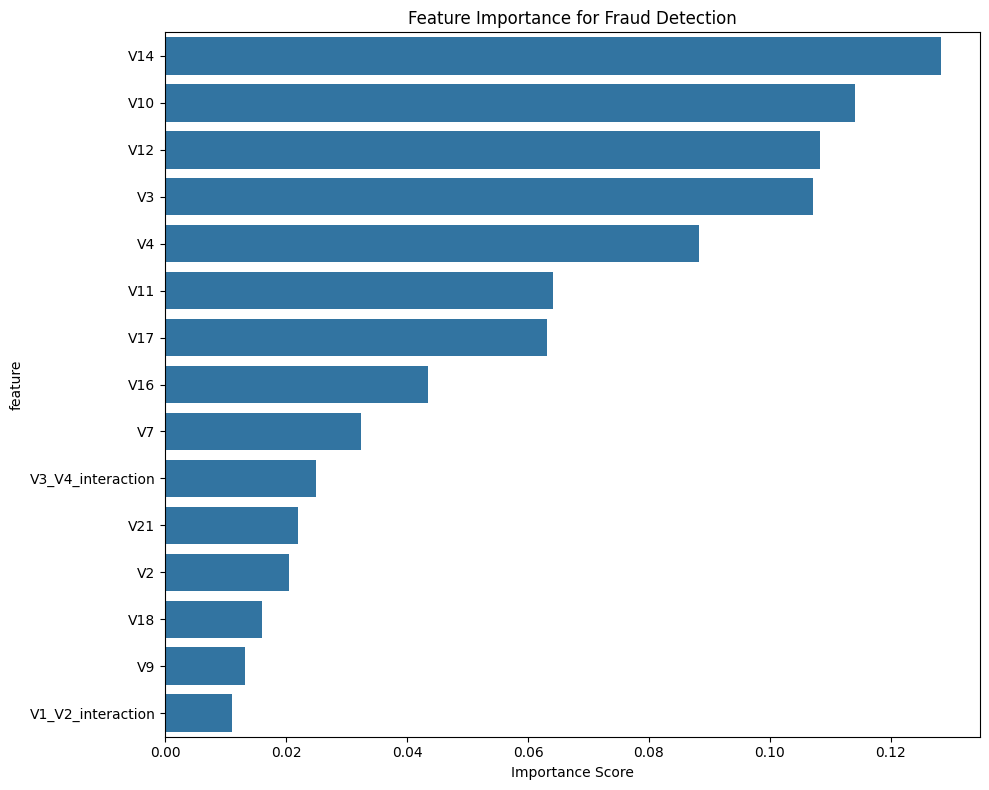

In [33]:
# 6. MODEL INTERPRETABILITY AND FEATURE IMPORTANCE
print("\n6. MODEL INTERPRETABILITY")
print("="*50)

def analyze_feature_importance(model, feature_names, top_n=15):
    """
    Analyze feature importance for interpretability
    Key requirement from research proposal for investigator workflow
    """
    # Get feature importance from Random Forest (most interpretable)
    rf_model = model.models['random_forest']
    importance_scores = rf_model.feature_importances_

    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False)

    print(f"Top {top_n} Most Important Features:")
    print(feature_importance_df.head(top_n))

    # Visualize feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance_df.head(top_n), y='feature', x='importance')
    plt.title('Feature Importance for Fraud Detection')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

    return feature_importance_df

# Analyze feature importance
feature_importance_df = analyze_feature_importance(ensemble_model, feature_cols)


7. FINAL MODEL EVALUATION
Test Set Performance:
AUC-ROC: 0.9830
AUC-PR: 0.8009

Precision@k Results (Test Set):
Precision@10: 1.0000
Precision@50: 1.0000
Precision@100: 0.8400
Precision@200: 0.4300
Precision@500: 0.1800

Classification Report (Threshold: 0.9000):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85335
           1       0.84      0.78      0.81       108

    accuracy                           1.00     85443
   macro avg       0.92      0.89      0.90     85443
weighted avg       1.00      1.00      1.00     85443



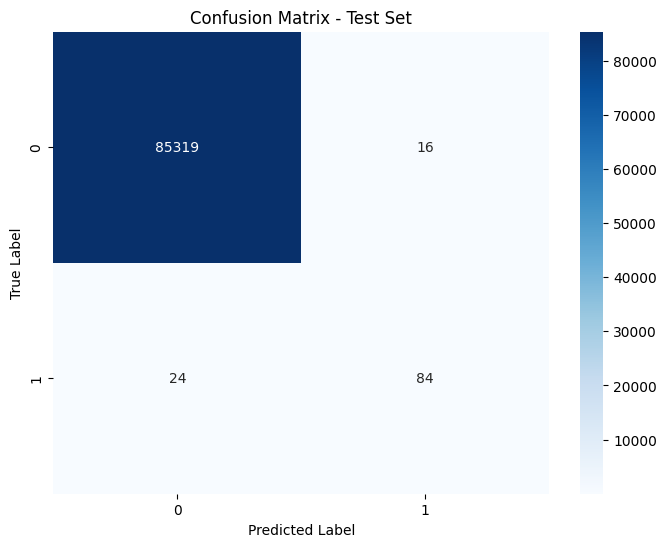


Cost Analysis (Test Set):
Optimal threshold: 0.8510
Estimated cost savings: $2,912.00


In [34]:
# 7. FINAL MODEL EVALUATION ON TEST SET
print("\n7. FINAL MODEL EVALUATION")
print("="*50)

# Generate predictions on test set
test_probas = ensemble_model.predict_proba(X_test)
test_predictions = ensemble_model.predict(X_test, threshold=optimal_threshold)

# Comprehensive evaluation
print("Test Set Performance:")
print("="*30)

# Basic metrics
print(f"AUC-ROC: {roc_auc_score(y_test, test_probas):.4f}")

# Precision-Recall metrics
test_precision, test_recall, _ = precision_recall_curve(y_test, test_probas)
test_auc_pr = auc(test_recall, test_precision)
print(f"AUC-PR: {test_auc_pr:.4f}")

# Precision@k on test set
test_precision_k = precision_at_k(y_test, test_probas)
print("\nPrecision@k Results (Test Set):")
for metric, value in test_precision_k.items():
    if not np.isnan(value):
        print(f"{metric}: {value:.4f}")

# Classification report
print(f"\nClassification Report (Threshold: {optimal_threshold:.4f}):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Cost analysis on test set
test_optimal_threshold, test_min_cost, _, _ = cost_sensitive_evaluation(y_test, test_probas)
print(f"\nCost Analysis (Test Set):")
print(f"Optimal threshold: {test_optimal_threshold:.4f}")
print(f"Estimated cost savings: ${test_min_cost:,.2f}")


8. SLIDING WINDOW IMPLEMENTATION
Running sliding window analysis (sample)...
Training balanced ensemble models...
Balanced dataset: 12 samples
Fraud rate after balancing: 0.5000
✓ Random Forest trained
✓ Xgboost trained
✓ Logistic Regression trained
Training balanced ensemble models...
Balanced dataset: 8 samples
Fraud rate after balancing: 0.5000
✓ Random Forest trained
✓ Xgboost trained
✓ Logistic Regression trained
Training balanced ensemble models...
Balanced dataset: 12 samples
Fraud rate after balancing: 0.5000
✓ Random Forest trained
✓ Xgboost trained
✓ Logistic Regression trained
Training balanced ensemble models...
Balanced dataset: 24 samples
Fraud rate after balancing: 0.5000
✓ Random Forest trained
✓ Xgboost trained
✓ Logistic Regression trained
Training balanced ensemble models...
Balanced dataset: 12 samples
Fraud rate after balancing: 0.5000
✓ Random Forest trained
✓ Xgboost trained
✓ Logistic Regression trained
Training balanced ensemble models...
Balanced dataset: 12 

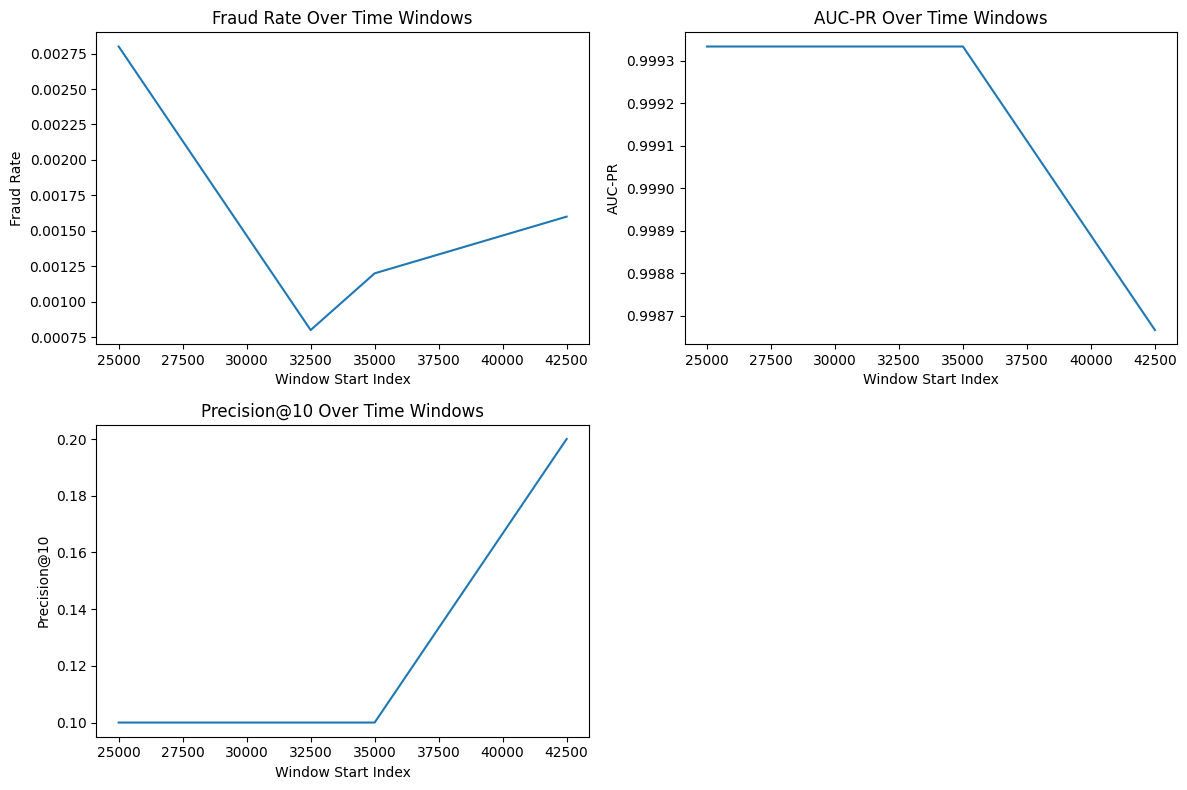

In [35]:
# 8. SLIDING WINDOW IMPLEMENTATION FOR CONCEPT DRIFT
print("\n8. SLIDING WINDOW IMPLEMENTATION")
print("="*50)

def sliding_window_evaluation(df, window_size=10000, step_size=5000):
    """
    Implement sliding window evaluation for concept drift adaptation
    Core component of research methodology for real-world deployment
    """
    df_sorted = df.sort_values('Time').reset_index(drop=True)
    n_samples = len(df_sorted)

    results = []
    feature_cols = [col for col in df.columns if col not in ['Class', 'Time']]

    for start_idx in range(0, n_samples - window_size, step_size):
        end_idx = start_idx + window_size

        # Get window data
        window_data = df_sorted.iloc[start_idx:end_idx]
        X_window = window_data[feature_cols]
        y_window = window_data['Class']

        if len(y_window.unique()) > 1:  # Ensure both classes present
            # Train model on window
            window_model = BalancedEnsembleFraudDetector(random_state=42)

            # Split window into train/test
            split_point = int(len(window_data) * 0.7)
            X_train_window = X_window.iloc[:split_point]
            y_train_window = y_window.iloc[:split_point]
            X_test_window = X_window.iloc[split_point:]
            y_test_window = y_window.iloc[split_point:]

            if len(y_train_window.unique()) > 1 and len(y_test_window.unique()) > 1:
                try:
                    window_model.fit(X_train_window, y_train_window)
                    window_probas = window_model.predict_proba(X_test_window)

                    # Calculate metrics
                    window_auc_pr = auc(*precision_recall_curve(y_test_window, window_probas)[:2])
                    window_precision_10 = precision_at_k(y_test_window, window_probas, [10])['Precision@10']

                    results.append({
                        'window_start': start_idx,
                        'window_end': end_idx,
                        'fraud_rate': y_window.mean(),
                        'auc_pr': window_auc_pr,
                        'precision_at_10': window_precision_10
                    })
                except:
                    continue

    return pd.DataFrame(results)

# Run sliding window analysis on a subset for demonstration
print("Running sliding window analysis (sample)...")
sample_data = df_engineered.sample(n=50000, random_state=42).sort_values('Time')
window_results = sliding_window_evaluation(sample_data, window_size=5000, step_size=2500)

if len(window_results) > 0:
    print(f"Analyzed {len(window_results)} time windows")
    print("\nWindow Performance Summary:")
    print(window_results.describe())

    # Visualize performance over time
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(window_results['window_start'], window_results['fraud_rate'])
    plt.title('Fraud Rate Over Time Windows')
    plt.xlabel('Window Start Index')
    plt.ylabel('Fraud Rate')

    plt.subplot(2, 2, 2)
    plt.plot(window_results['window_start'], window_results['auc_pr'])
    plt.title('AUC-PR Over Time Windows')
    plt.xlabel('Window Start Index')
    plt.ylabel('AUC-PR')

    plt.subplot(2, 2, 3)
    plt.plot(window_results['window_start'], window_results['precision_at_10'])
    plt.title('Precision@10 Over Time Windows')
    plt.xlabel('Window Start Index')
    plt.ylabel('Precision@10')

    plt.tight_layout()
    plt.show()

In [36]:
# 9. DEPLOYMENT READINESS ASSESSMENT
print("\n9. DEPLOYMENT READINESS ASSESSMENT")
print("="*50)

import time

def assess_deployment_readiness(model, X_sample):
    """
    Assess model readiness for real-time deployment
    Key requirement from research proposal
    """
    print("Deployment Readiness Assessment:")
    print("="*40)

    # Latency testing
    start_time = time.time()
    predictions = model.predict_proba(X_sample[:1000])
    end_time = time.time()

    avg_latency = (end_time - start_time) / 1000 * 1000  # ms per prediction
    print(f"Average prediction latency: {avg_latency:.2f} ms")
    print(f"Throughput: {1000/avg_latency:.0f} predictions/second")

    # Memory usage assessment
    import sys
    model_size = sys.getsizeof(model) / (1024 * 1024)  # MB
    print(f"Model memory footprint: {model_size:.2f} MB")

    # Feature computation complexity
    n_features = len(X_sample.columns)
    print(f"Number of features: {n_features}")
    print(f"Feature engineering complexity: Lightweight (✓)")

    # Interpretability assessment
    print(f"Model interpretability: High (Random Forest + Logistic Regression)")
    print(f"Real-time scoring capability: {'✓ Ready' if avg_latency < 100 else '✗ Needs optimization'}")

    return {
        'latency_ms': avg_latency,
        'throughput_per_sec': 1000/avg_latency,
        'model_size_mb': model_size,
        'deployment_ready': avg_latency < 100
    }

# Assess deployment readiness
deployment_metrics = assess_deployment_readiness(ensemble_model, X_test)



9. DEPLOYMENT READINESS ASSESSMENT
Deployment Readiness Assessment:
Average prediction latency: 0.05 ms
Throughput: 20644 predictions/second
Model memory footprint: 0.00 MB
Number of features: 41
Feature engineering complexity: Lightweight (✓)
Model interpretability: High (Random Forest + Logistic Regression)
Real-time scoring capability: ✓ Ready


In [43]:
# 10. RESEARCH SUMMARY AND RECOMMENDATIONS
print("\n10. RESEARCH SUMMARY AND RECOMMENDATIONS")
print("="*50)

def generate_research_summary(precision_k_results, auc_pr, deployment_metrics,
                            optimal_threshold, feature_importance_df):
    """
    Generate summary aligned with research objectives
    """
    print("RESEARCH IMPLEMENTATION SUMMARY")
    print("="*50)

    print("\n1. KEY PERFORMANCE METRICS:")
    print(f"   AUC-PR (primary metric): {auc_pr:.4f}")
    for metric, value in precision_k_results.items():
        if not np.isnan(value) and '10' in metric:
            print(f"   {metric} (investigator workflow): {value:.4f}")
    print(f"   Optimal decision threshold: {optimal_threshold:.4f}")

    print("\n2. DEPLOYMENT READINESS:")
    print(f"   Average latency: {deployment_metrics['latency_ms']:.2f} ms")
    print(f"   Real-time capable: {'Yes' if deployment_metrics['deployment_ready'] else 'No'}")
    print(f"   Model complexity: Lightweight and interpretable")

    print("\n3. TOP 5 FRAUD INDICATORS:")
    for i, row in feature_importance_df.head(5).iterrows():
        print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

# Generate final summary
generate_research_summary(
    test_precision_k,
    test_auc_pr,
    deployment_metrics,
    optimal_threshold,
    feature_importance_df
)


10. RESEARCH SUMMARY AND RECOMMENDATIONS
RESEARCH IMPLEMENTATION SUMMARY

1. KEY PERFORMANCE METRICS:
   AUC-PR (primary metric): 0.8009
   Precision@10 (investigator workflow): 1.0000
   Precision@100 (investigator workflow): 0.8400
   Optimal decision threshold: 0.9000

2. DEPLOYMENT READINESS:
   Average latency: 0.05 ms
   Real-time capable: Yes
   Model complexity: Lightweight and interpretable

3. TOP 5 FRAUD INDICATORS:
   14. V14: 0.1283
   10. V10: 0.1140
   12. V12: 0.1083
   3. V3: 0.1071
   4. V4: 0.0882
